### 라이브러리 가져오기

In [36]:
import os
import random
import timm
import time
import pickle
from scipy import stats

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn as nn

from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix



from PIL import Image
from tqdm import tqdm

import cv2
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import logging
import sys

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', 
                    handlers=[logging.FileHandler('notebook.log'), logging.StreamHandler()])

### CONFIG

In [3]:
class CONFIG:

    @staticmethod
    def set_seed(SEED):
        os.environ['PYTHONHASHSEED'] = str(SEED)
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.benchmark = True
    
    @staticmethod
    def set_path(root_path):
        train_path = f'{root_path}/train/'
        test_path = f'{root_path}/test/'

        return root_path, train_path, test_path

In [4]:
CONFIG.set_seed(0xC0FFE)
root_path, train_path, test_path = CONFIG.set_path('/root/Project/new_data')

logging.info('1. Set Seed')

2024-04-19 13:14:50,206 - INFO - 1. Set Seed


### 전처리된 파일 불러오기

In [5]:
train_file = pd.read_csv(f'{root_path}/combined_data.csv')
train_file.head(3)

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10


In [6]:
sorted_train_file = train_file.sort_values(by='target')
sorted_train_file.head(3)

,ID,target
26516,df1caa3d9f344b5a_Rotated_90.jpg,0
35151,voronoi1_293316f2c9939133_Rotated__39.jpg,0
35150,voronoi1_293316f2c9939133_Rotated__113.jpg,0


In [7]:
test_file = pd.read_csv(f'{root_path}/sample_submission.csv')
test_file.head(3)

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0


### Stratified K-Fold

In [8]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        # print(f"Fold {ii} :")
        # print(f"  Train : index={tr[:5]}...")
        # print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

<Axes: title={'center': 'Stratified K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

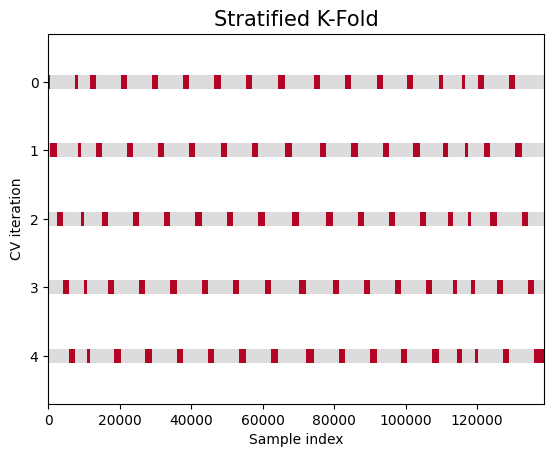

In [9]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5)
fig, ax = plt.subplots()
plot_cv_indices(x=sorted_train_file['ID'],
                y=sorted_train_file['target'],
                cv=skf,
                ax=ax,
                split_strategy='Stratified K-Fold')

In [10]:
train_folds = skf.split(sorted_train_file['ID'], sorted_train_file['target'])

### CustomDataset

In [11]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    
logging.info('2. Define Dataset Class')

2024-04-19 13:14:58,369 - INFO - 2. Define Dataset Class


### 모델 학습

In [12]:
# one epoch 학습을 위한 함수입니다.
def _train_one_epoch(loader, model, optimizer, loss_fn, scheduler, scaler, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        with autocast():
            preds = model(images)
            loss = loss_fn(preds, targets)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")
    
    scheduler.step()

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [13]:
# one epoch 학습을 위한 함수입니다.
def _val_one_epoch(loader, model, device):
    model.eval()
    
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)
        with torch.no_grad():
            preds = model(images)

        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret, train_f1

In [39]:
# 하이퍼파라미터 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'swin_large_patch4_window7_224'  # 모델명
img_size = 224
learning_rate = 1e-4
num_epochs = 10
batch_size = 32
num_workers = 8
patience = 3
T_0 = 5
T_mult = 2
eta_min = 1e-6

train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size, always_apply=True), 
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=(255, 255, 255)), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

logging.info('3. Set Hyperparameter')

2024-04-19 13:50:00,049 - INFO - 3. Set Hyperparameter


In [15]:
# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(sorted_train_file['target']), y=sorted_train_file['target'])
print(class_weights)

alpha = torch.tensor(class_weights, dtype=torch.float64).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        # alpha 값을 targets의 크기에 맞게 브로드캐스팅
        alpha = self.alpha.gather(0, targets.long())

        focal_loss = alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            focal_loss = focal_loss.mean()
        elif self.reduction == 'sum':
            focal_loss = focal_loss.sum()
        return focal_loss
    
# loss_fn = FocalLoss(alpha=alpha, gamma=2)
logging.info('4. Define Focal Loss')

2024-04-19 13:15:02,306 - INFO - 4. Define Focal Loss


[0.92764706 2.01662404 0.95143288 0.93701723 0.93701723 0.92764706
 0.92764706 0.91846243 0.80664962 0.92764706 0.92764706 0.95633717
 0.92764706 1.25357711 1.8189158  0.92764706 0.95143288]


In [68]:
'''
def tta(model, loader, device):
    model.eval()
    final_preds = []

    with torch.no_grad():
        for images, _ in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            flipped_images = torch.flip(images, dims=[3])
            outputs_flipped = model(flipped_images)
            probabilities_flipped = torch.nn.functional.softmax(outputs_flipped, dim=1)


            rotations = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
            rotated_probabilities = []

            for angle in rotations:
                # 정규화 된 이미지[-1, 1]에서 흰색은 (1, 1, 1)
                rotated_images = TF.rotate(images, angle, fill=(1, 1, 1))
                outputs_rotated = model(rotated_images)

                probabilities_rotated = torch.nn.functional.softmax(outputs_rotated, dim=1)
                rotated_probabilities.append(probabilities_rotated)

            averaged_probabilities = (probabilities + probabilities_flipped + sum(rotated_probabilities)) / (len(rotations) + 2)
            # preds = averaged_probabilities.argmax(dim=1)
            final_preds.extend(averaged_probabilities.cpu().numpy())
            
    return final_preds
'''


In [90]:
def tta(model, loader, device):
    model.eval()
    final_preds = []
    rot_transform = A.Compose([
        A.Rotate(limit=(0, 0), p=1.0, border_mode=cv2.BORDER_CONSTANT, value=(1, 1, 1))
    ])

    with torch.no_grad():
        for images, _ in tqdm(loader):
            images = images.to(device)

            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            flipped_images = torch.flip(images, dims=[3])
            outputs_flipped = model(flipped_images)
            probabilities_flipped = torch.nn.functional.softmax(outputs_flipped, dim=1)

            rotations = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
            rotated_probabilities = []
            for angle in rotations:
                rot_transform.transforms[0].limit = (angle, angle)
                rotated_images = []
                for img in images:
                    img_np = img.permute(1, 2, 0).cpu().numpy()
                    rotated_img = rot_transform(image=img_np)['image']
                    rotated_img_tensor = torch.from_numpy(rotated_img).permute(2, 0, 1).to(device)
                    rotated_images.append(rotated_img_tensor)
                rotated_images = torch.stack(rotated_images)

                outputs_rotated = model(rotated_images)
                probabilities_rotated = torch.nn.functional.softmax(outputs_rotated, dim=1)
                rotated_probabilities.append(probabilities_rotated)

            averaged_probabilities = (probabilities + probabilities_flipped + sum(rotated_probabilities)) / (len(rotations) + 2)
            # preds = averaged_probabilities.argmax(dim=1)
            final_preds.extend(averaged_probabilities.cpu().numpy())
    return final_preds

In [23]:
'''
from sklearn.base import BaseEstimator, ClassifierMixin

class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator(X).argmax(dim=1).detach().cpu().tolist() for estimator in self.estimators]
        return stats.mode(y_preds)[0]
'''


'\nfrom sklearn.base import BaseEstimator, ClassifierMixin\n\nclass VotingModel(BaseEstimator, ClassifierMixin):\n    def __init__(self, estimators):\n        super().__init__()\n        self.estimators = estimators\n        \n    def fit(self, X, y=None):\n        return self\n    \n    def predict(self, X):\n        y_preds = [estimator(X).argmax(dim=1).detach().cpu().tolist() for estimator in self.estimators]\n        return stats.mode(y_preds)[0]\n'

In [31]:
def train_model(patience, num_epochs, device):

    # 시작 시간
    since = time.time()

    models = []
    
    for fold_index, (train_index, validation_index) in enumerate(train_folds):

        # 그라디언트 스케일러 초기화
        scaler = GradScaler()
  
        print()
        print(f'Stratified K-Fold: {fold_index}')
        logging.info(f'Stratified K-Fold: {fold_index + 1} / 5')
        print('-' * 10)

        model = timm.create_model(
            model_name=model_name,
            pretrained=True,
            num_classes=17
        ).to(device)

        loss_fn = FocalLoss(alpha=alpha, gamma=2)
        optimizer = Adam(model.parameters(), lr=learning_rate)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min)
        
        # train
        train_data = sorted_train_file.iloc[train_index, :]
        train_dataset = ImageDataset(
            df=train_data,
            path=train_path,
            transform=train_transform
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=False
        )

        # validation
        validation_data = sorted_train_file.iloc[validation_index, :]
        validation_dataset = ImageDataset(
            df=validation_data,
            path=train_path,
            transform=train_transform
        )
        validation_loader = DataLoader(
            validation_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=False
        )

        best_epoch = 0
        best_f1_score = 0
        early_stop_counter = 0
        best_model_weights = None

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            logging.info(f"Epoch {epoch + 1}/{num_epochs}")

            if early_stop_counter >= patience:
                logging.info(f"Early Stopping... epoch {epoch + 1}")
                print("Early Stopping....\n")
                break

            # train
            ret = _train_one_epoch(train_loader, model, optimizer, loss_fn, scheduler, scaler, device)
            # validation
            ret2, val_f1 = _val_one_epoch(validation_loader, model, device)

            print(f"Loss: {ret['train_loss']:.4f}, train Accuracy: {ret['train_acc']:.4f}, train F1-Score: {ret['train_f1']:.4f}")
            print(f"validation Accuracy: {ret2['train_acc']:.4f}, validation F1-Score: {ret2['train_f1']:.4f}")
            print('-' * 10)
            
            # f1-score을 비교
            if val_f1 > best_f1_score:
                early_stop_counter = 0

                best_epoch = epoch
                best_f1_score = val_f1
                best_model_weights = model.state_dict()
                
            else:
                early_stop_counter += 1

    
        print(f'best epoch: {best_epoch}, best f1 score: {best_f1_score}')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # 가장 좋은 모델의 가중치(w) 가져오기
        model.load_state_dict(best_model_weights)
    
        model_path = f'{root_path}/model/{model_name}_all'
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        with open(f'{model_path}/fold_{fold_index}' + '.pkl', 'wb') as f:
            pickle.dump(model, f)

        models.append({
            'model': model,
            'weights': best_model_weights,
            'f1_score': best_f1_score,
        })
        
    return models

In [ ]:
logging.info('6. Start Training')
logging.info('----------------------------------------------')

In [ ]:
# 훈련하기
models = train_model(patience, num_epochs=num_epochs, device=device)

In [ ]:

logging.info('----------------------------------------------')
logging.info('7. Finish Training')

In [17]:
# 모델 불러오기
models = []

for i in range(5):
    with open(f'{root_path}/model/{model_name}_all/fold_{i}.pkl', 'rb') as f:
        model = pickle.load(f)
    models.append(model) 

# model = VotingModel(models)



### Confusion Matrix

어떤 클래스를 잘 맞추고, 잘 못맞추는지 확인하기

In [ ]:
'''
def plot_cm(model:VotingModel, sample_dataloader, device):
    total_labels = []
    total_preds = []

    for images, labels in tqdm(sample_dataloader):
        images = images.to(device)
        labels = labels

        predicts = model.predict(images)

        total_preds.extend(predicts.tolist())
        total_labels.extend(labels.tolist())

    total_preds = np.array(total_preds)
    total_labels = np.array(total_labels)
    _f1_score = f1_score(total_labels, total_preds, average='macro')
    print("Model f1_score : ", _f1_score)

    cm = confusion_matrix(total_labels, total_preds)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
'''


In [ ]:
'''
# 클래스 별 20% 랜덤 추출
sample_file = pd.DataFrame(columns=['ID', 'target'])

for i in range(17):
    temp = sorted_train_file.loc[sorted_train_file['target'] == i].sample(frac=0.2, random_state=0xC0FFE)
    sample_file = pd.concat([sample_file, temp], axis=0)
    

sample_dataset = ImageDataset(
    df=sample_file,
    path=train_path,
    transform=train_transform
)
sample_loader = DataLoader(
    sample_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)
# plot_cm(model, sample_loader, device)
'''


### Inference & Submisson

In [86]:
test_dataset = ImageDataset(
    df=test_file,
    path=test_path,
    transform=test_transform,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [ ]:
result_path = f"{root_path}/result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

# Soft Voting
ensemble_preds_soft = []
for model_info in models:
    # shape (model 수, test data 이미지 수, class 수) --> (5, 3140, 17)
    ensemble_preds_soft.append(tta(model_info['model'], test_loader, device))

# shape (test data 이미지 수, class 수) --> (3140, 17)
ensemble_preds_soft = np.mean(ensemble_preds_soft, axis=0)
# shape (test data 이미지 수) --> (3140, )
final_preds_soft = np.argmax(ensemble_preds_soft, axis=1)

submission_df_soft = pd.read_csv(f'{root_path}/sample_submission.csv')
submission_df_soft['target'] = final_preds_soft
submission_df_soft.to_csv(f'{result_path}/{model_name}_submission_soft.csv', index=False)


# Weighted Voting
weights = [model_info['f1_score'] for model_info in models]
weights = np.array(weights) / sum(weights)

ensemble_preds_weighted = []
for model_info, weight in zip(models, weights):
    ensemble_preds_weighted.append(weight * np.array(tta(model_info['model'], test_loader, device)))

ensemble_preds_weighted = np.sum(ensemble_preds_weighted, axis=0)
final_preds_weighted = np.argmax(ensemble_preds_weighted, axis=1)

submission_df_weighted = pd.read_csv(f'{root_path}/sample_submission.csv')
submission_df_weighted['target'] = final_preds_weighted
submission_df_weighted.to_csv(f'{result_path}/{model_name}_submission_weighted.csv', index=False)

logging.info('8. Predict')

In [92]:
# 모델을 가져왔을 때

'''
result_path = f"{root_path}/result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

# Soft Voting
ensemble_preds_soft = []
for model in models:
    # shape (model 수, test data 이미지 수, class 수) --> (5, 3140, 17)
    ensemble_preds_soft.append(tta2(model, test_loader, device))
    
# shape (test data 이미지 수, class 수) --> (3140, 17)
ensemble_preds_soft = np.mean(ensemble_preds_soft, axis=0)
# shape (test data 이미지 수) --> (3140, )
final_preds_soft = np.argmax(ensemble_preds_soft, axis=1)

submission_df_soft = pd.read_csv(f'{root_path}/sample_submission.csv')
submission_df_soft['target'] = final_preds_soft
submission_df_soft.to_csv(f'{result_path}/{model_name}_submission_soft.csv', index=False)
'''

'\nresult_path = f"{root_path}/result"\nif not os.path.exists(result_path):\n    os.makedirs(result_path)\n\n# Soft Voting\nensemble_preds_soft = []\nfor model in models:\n    # shape (model 수, test data 이미지 수, class 수) --> (5, 3140, 17)\n    ensemble_preds_soft.append(tta2(model, test_loader, device))\n    \n# shape (test data 이미지 수, class 수) --> (3140, 17)\nensemble_preds_soft = np.mean(ensemble_preds_soft, axis=0)\n# shape (test data 이미지 수) --> (3140, )\nfinal_preds_soft = np.argmax(ensemble_preds_soft, axis=1)\n\nsubmission_df_soft = pd.read_csv(f\'{root_path}/sample_submission.csv\')\nsubmission_df_soft[\'target\'] = final_preds_soft\nsubmission_df_soft.to_csv(f\'{result_path}/{model_name}_submission_soft.csv\', index=False)\n'